## Balanced workloads

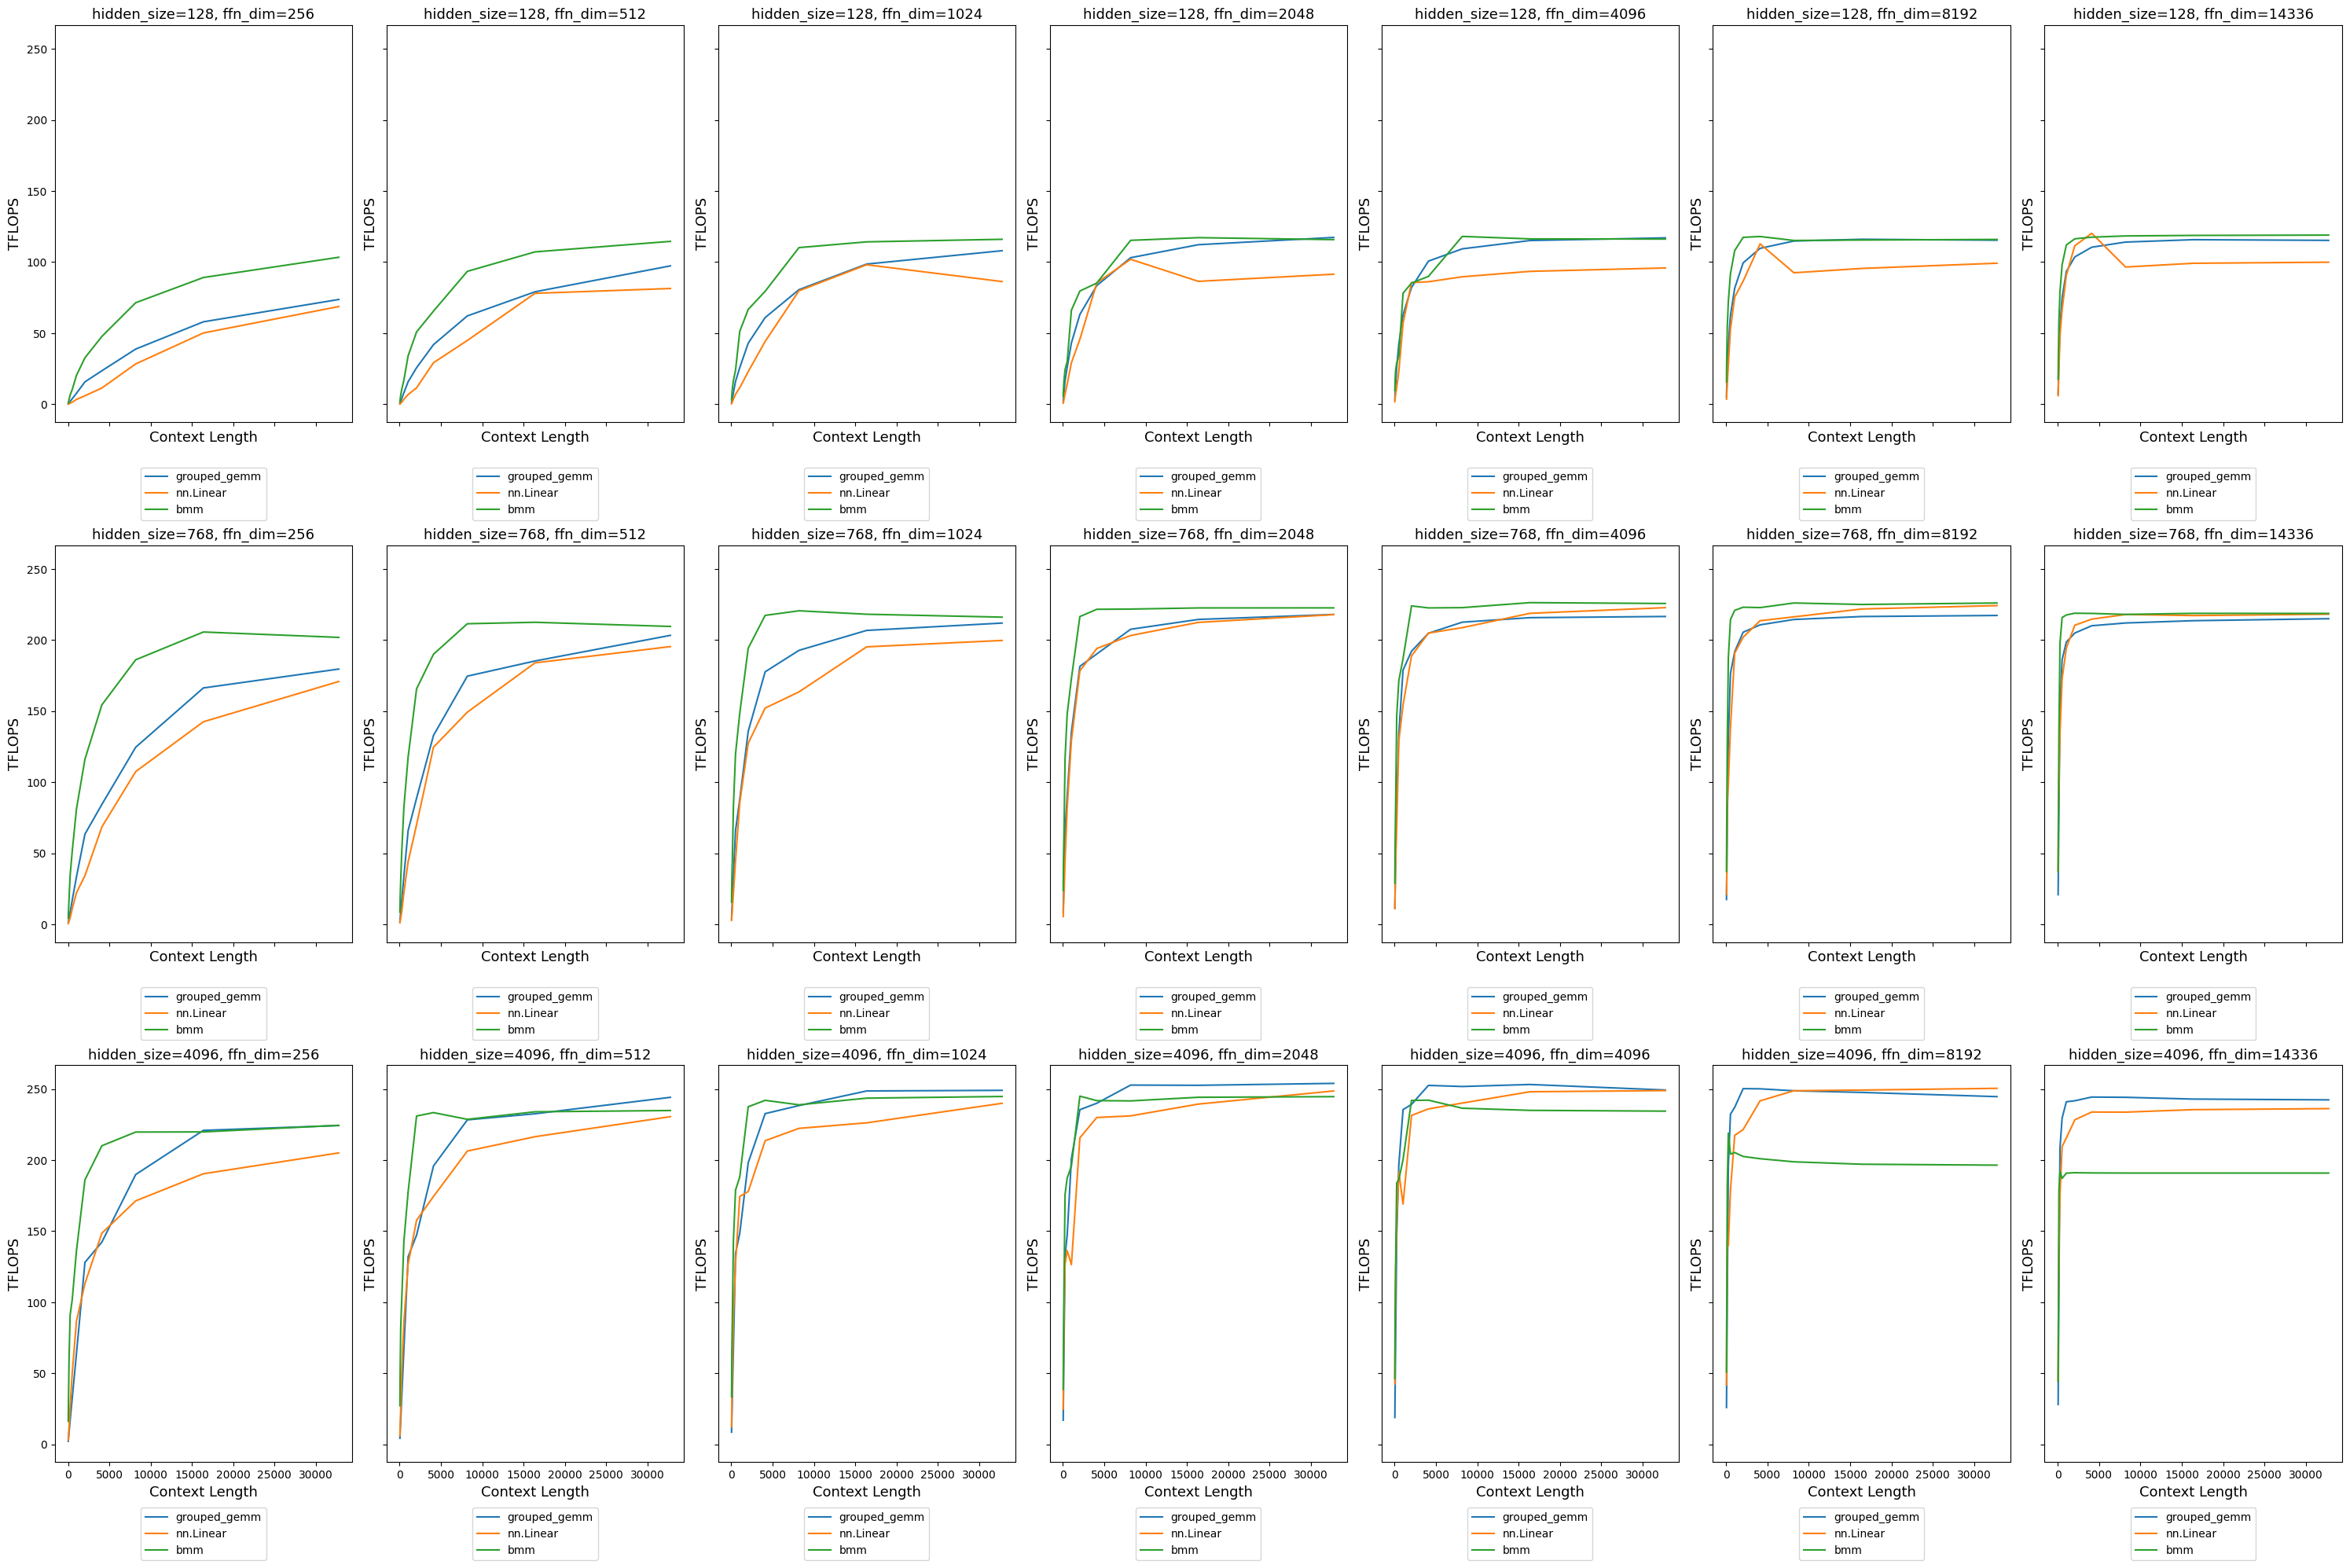

In [5]:
import matplotlib.pyplot as plt

# Read the data file
with open('perf_8_32768_balanced.txt', 'r') as file:
    data = file.read()

parts = data.split('-' * 50)

batch_sizes = [1]
sequence_lengths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768] # max sequence length, or the context length, M
hidden_sizes = [128, 768, 4096] # N
ffn_dims = [256, 512, 1024, 2048, 4096, 8192, 14336] # K

grouped_gemm_tflops = {}
nn_linear_tflops = {}
bmm_tflops = {}

# Traverse each part and extract the relevant information
for part in parts:
    lines = part.strip().split('\n')
    if len(lines) < 10:
        continue
    
    params = lines[0].split(':')[1].split(',')
    batch_size = int(params[0].split('=')[1])
    sequence_length = int(params[1].split('=')[1])
    hidden_size = int(params[2].split('=')[1])
    ffn_dim = int(params[3].split('=')[1])
    
    if (batch_size, hidden_size, ffn_dim) not in grouped_gemm_tflops:
        grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)] = []
        nn_linear_tflops[(batch_size, hidden_size, ffn_dim)] = []
        bmm_tflops[(batch_size, hidden_size, ffn_dim)] = []
    
    for line in lines:
        if 'TFLOPS (grouped_gemm):' in line:
            grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (nn.Linear):' in line:
            nn_linear_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (bmm):' in line:
            bmm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))

# Create subplots for each parameter combination
fig, axs = plt.subplots(len(hidden_sizes), len(ffn_dims), figsize=(30, 20), sharex=True, sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, ffn_dim in enumerate(ffn_dims):
        ax = axs[i, j]
        
        for batch_size in batch_sizes:
            key = (batch_size, hidden_size, ffn_dim)
            if key in grouped_gemm_tflops:
                ax.plot(sequence_lengths[:len(grouped_gemm_tflops[key])], grouped_gemm_tflops[key], label=f'grouped_gemm')
                ax.plot(sequence_lengths[:len(nn_linear_tflops[key])], nn_linear_tflops[key], label=f'nn.Linear')
                ax.plot(sequence_lengths[:len(bmm_tflops[key])], bmm_tflops[key], label=f'bmm')
        
        ax.set_title(f'hidden_size={hidden_size}, ffn_dim={ffn_dim}', fontsize=13)
        ax.set_xlabel('Context Length', fontsize=13)
        ax.set_ylabel('TFLOPS', fontsize=13)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

### Takeaways

For the balanced case:
1. For smaller matrices, BMM (with padding) is the fastest; for extremely large matrices, BMM is slower. 
2. Grouped GEMM outperforms nn.linear on small matrices, performs similarly on large ones. 
3. Batched with zero padding is the best choice for balanced workloads when the matrices are not extremely large, and grouped gemm / nn.linear is the best choice when the matrices are extremely large. 

## Imbalanced workloads

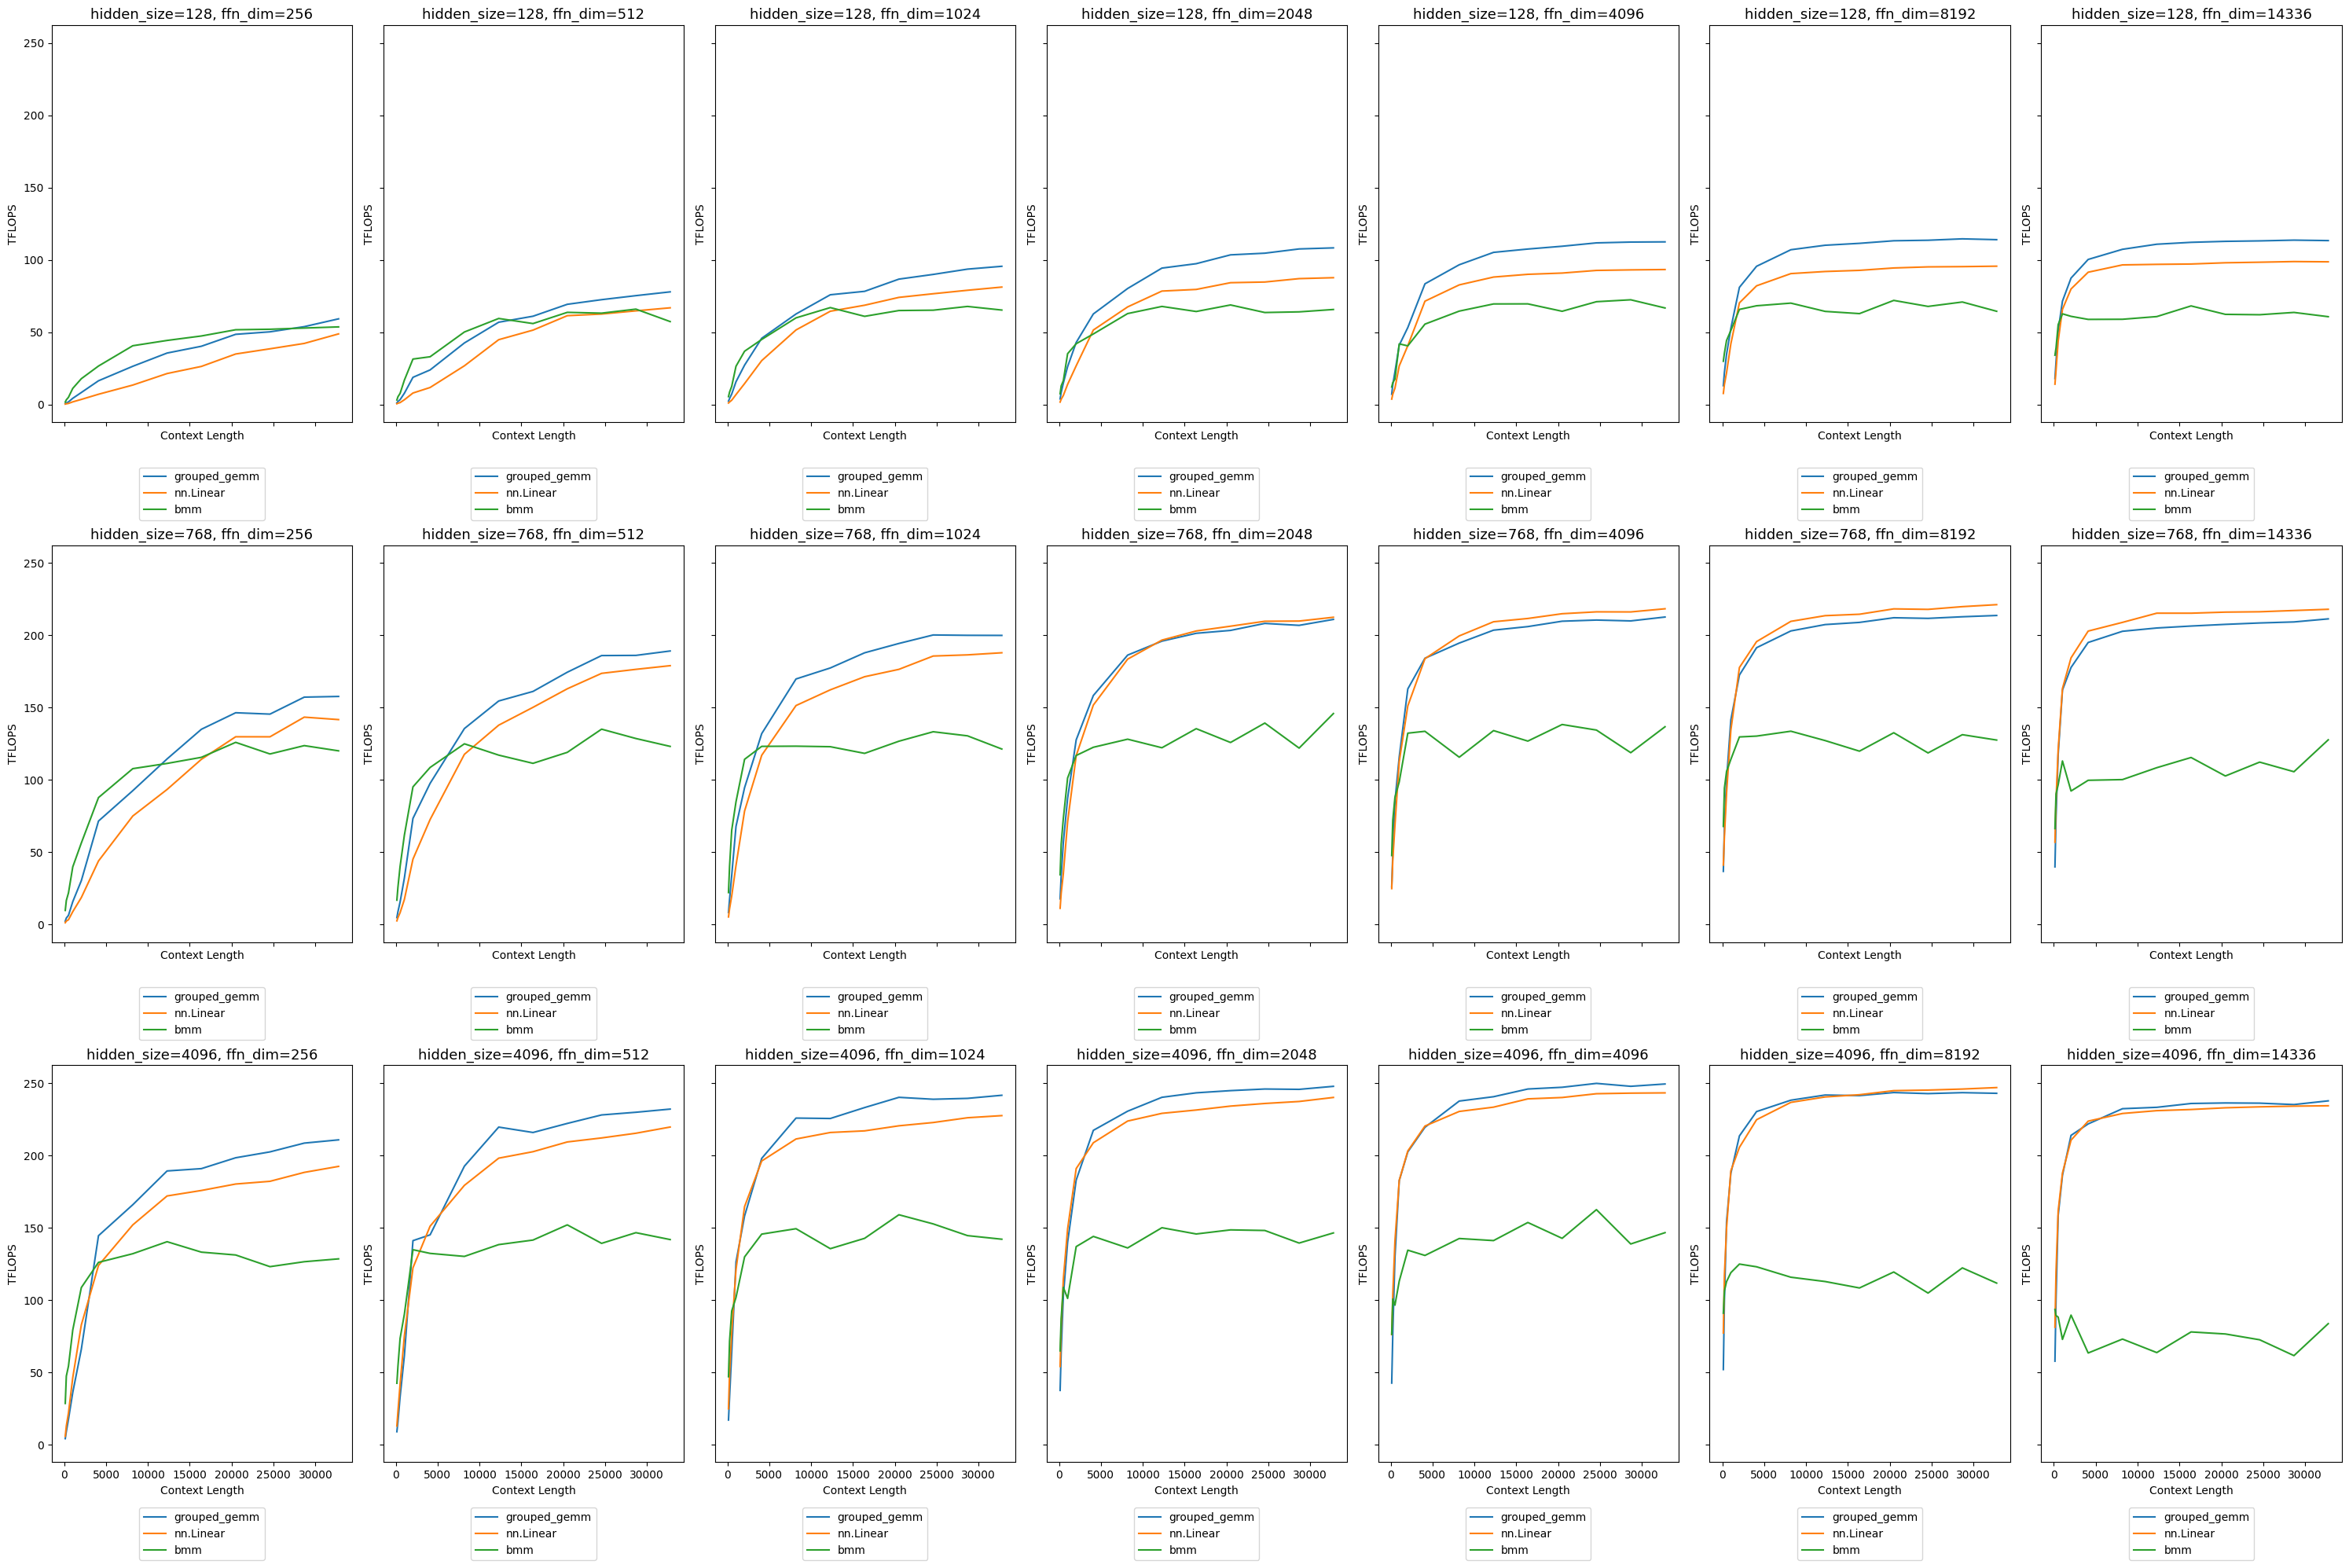

In [4]:
import matplotlib.pyplot as plt

# Read the data file
with open('perf_8_32768_imbalanced.txt', 'r') as file:
    data = file.read()

parts = data.split('--------------------------------------------------')
batch_sizes = [1]
sequence_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]
hidden_sizes = [128, 768, 4096]
ffn_dims = [256, 512, 1024, 2048, 4096, 8192, 14336]

grouped_gemm_tflops = {}
nn_linear_tflops = {}
a_b_tflops = {}
bmm_tflops = {}

# Traverse each part and extract the relevant information
for part in parts:
    lines = part.strip().split('\n')
    if len(lines) < 5:
        continue
    params = lines[0].split(':')[1].split(',')
    batch_size = int(params[0].split('=')[1])
    sequence_length = int(params[1].split('=')[1])
    hidden_size = int(params[2].split('=')[1])
    ffn_dim = int(params[3].split('=')[1])
    
    if (batch_size, hidden_size, ffn_dim) not in grouped_gemm_tflops:
        grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)] = []
        nn_linear_tflops[(batch_size, hidden_size, ffn_dim)] = []
        bmm_tflops[(batch_size, hidden_size, ffn_dim)] = []
    
    for line in lines:
        if 'TFLOPS (grouped_gemm):' in line:
            grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (nn.Linear):' in line:
            nn_linear_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (bmm):' in line:
            bmm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))

# Create subplots for each parameter combination
fig, axs = plt.subplots(len(hidden_sizes), len(ffn_dims), figsize=(30, 20), sharex=True, sharey=True)
for i, hidden_size in enumerate(hidden_sizes):
    for j, ffn_dim in enumerate(ffn_dims):
        ax = axs[i, j]
        for batch_size in batch_sizes:
            key = (batch_size, hidden_size, ffn_dim)
            if key in grouped_gemm_tflops:
                ax.plot(sequence_lengths[:len(grouped_gemm_tflops[key])], grouped_gemm_tflops[key], label=f'grouped_gemm')
                ax.plot(sequence_lengths[:len(nn_linear_tflops[key])], nn_linear_tflops[key], label=f'nn.Linear')
                ax.plot(sequence_lengths[:len(bmm_tflops[key])], bmm_tflops[key], label=f'bmm')
        ax.set_title(f'hidden_size={hidden_size}, ffn_dim={ffn_dim}', fontsize=13)
        ax.set_xlabel('Context Length')
        ax.set_ylabel('TFLOPS')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

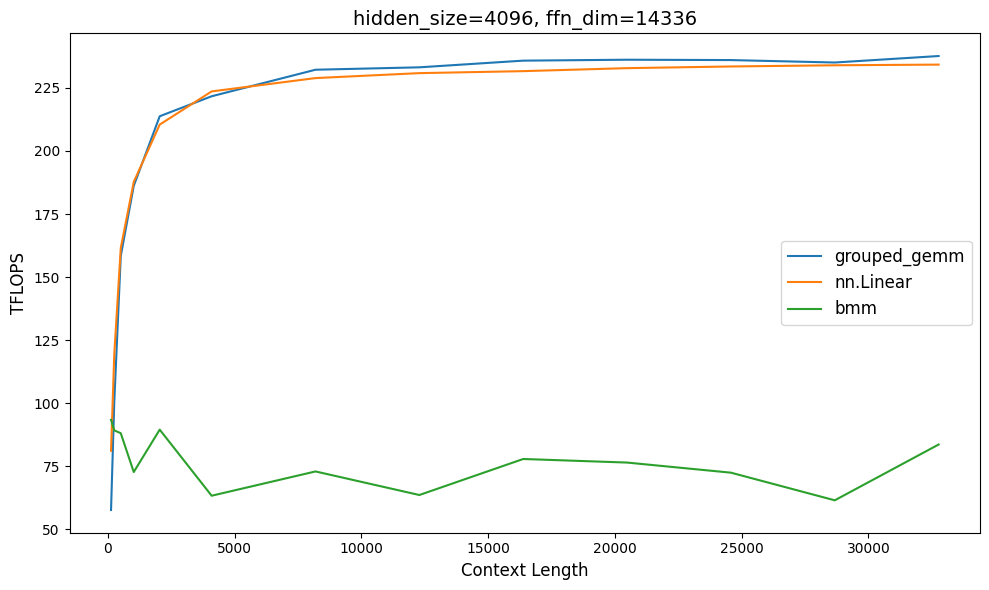

In [3]:
import matplotlib.pyplot as plt

# Read the data file
with open('perf_8_32768_imbalanced.txt', 'r') as file:
    data = file.read()

parts = data.split('--------------------------------------------------')
batch_sizes = [1]
sequence_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]
hidden_size = 4096
ffn_dim = 14336

grouped_gemm_tflops = {}
nn_linear_tflops = {}
bmm_tflops = {}

# Traverse each part and extract the relevant information
for part in parts:
    lines = part.strip().split('\n')
    if len(lines) < 5:
        continue
    params = lines[0].split(':')[1].split(',')
    batch_size = int(params[0].split('=')[1])
    sequence_length = int(params[1].split('=')[1])
    hidden_size_part = int(params[2].split('=')[1])
    ffn_dim_part = int(params[3].split('=')[1])
    
    if hidden_size_part != hidden_size or ffn_dim_part != ffn_dim:
        continue
    
    if (batch_size, hidden_size, ffn_dim) not in grouped_gemm_tflops:
        grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)] = []
        nn_linear_tflops[(batch_size, hidden_size, ffn_dim)] = []
        bmm_tflops[(batch_size, hidden_size, ffn_dim)] = []
    
    for line in lines:
        if 'TFLOPS (grouped_gemm):' in line:
            grouped_gemm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (nn.Linear):' in line:
            nn_linear_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))
        elif 'TFLOPS (bmm):' in line:
            bmm_tflops[(batch_size, hidden_size, ffn_dim)].append(float(line.split(':')[1]))

# Create a figure and plot the data
plt.figure(figsize=(10, 6))
ax = plt.gca()

for batch_size in batch_sizes:
    key = (batch_size, hidden_size, ffn_dim)
    if key in grouped_gemm_tflops:
        ax.plot(sequence_lengths[:len(grouped_gemm_tflops[key])], grouped_gemm_tflops[key], label=f'grouped_gemm')
        ax.plot(sequence_lengths[:len(nn_linear_tflops[key])], nn_linear_tflops[key], label=f'nn.Linear')
        ax.plot(sequence_lengths[:len(bmm_tflops[key])], bmm_tflops[key], label=f'bmm')

ax.set_title(f'hidden_size={hidden_size}, ffn_dim={ffn_dim}', fontsize=14)
ax.set_xlabel('Context Length', fontsize=12)
ax.set_ylabel('TFLOPS', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_xlim(0, 10000)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

```bash
Parameters: context_length=32768, hidden_size=4096, ffn_dim=14336
TFLOPS (grouped_gemm): 237.656
TFLOPS (nn.Linear): 234.255
TFLOPS (a @ b): 234.308
TFLOPS (bmm): 83.590
```

### Takeaways

For the imbalanced case:
1. BMM (with padding) is the slowest. 
2. Grouped GEMM is the fastest when at least two dimensions are small. 